In [91]:
colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import os # Configure which GPU
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) # Avoid warnings from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.random.set_seed(1) # Set global random seed for reproducibility

#### https://github.com/bayesian-optimization/BayesianOptimization/tree/master/examples

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Import Sionna RT components
# from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Paths2CIR
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera,Paths

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
import sys
import math
import copy
import matplotlib.patches as patches
import json
import shapely
from shapely.geometry import shape
from shapely.ops import transform
from matplotlib.patches import Polygon

### Use version pip install sionna==0.16.0

In [146]:
BASE_SCENE_PATH = "../sionna_scenes/PHILLIPINES_-3368426.748816584_18070032.87271823"
CAMERA_HEIGHT = 1500
CAMERA_ALPHA = -5.353052845685392
CAMERA_BETA = 1.5707963267948966
CAMERA_GAMA = 0
selected_rectangle = [[[121.024018, 14.556433], [121.024018, 14.556911], [121.024834, 14.556911], [121.024834, 14.556433], [121.024018, 14.556433]]]
target_size = np.array([200.,100.]) # Size
target_orientation = tf.Variable([0.,0.,0.]) # Orientation: parallel to XY
cm_cell_size = np.array([2.,2.]) # Each cell is 2mx2m
scene = None
scene_cam = None
X_offset = None
Y_offset = None
Z_offset = None
FREQUENCY = 3500 # Frequency in megahertz. This will change radio properties
LOS = True
REFLECTION = False
DIFFRACTION = False
SCATTERING = False
alpha_variable = tf.Variable(initial_value=[0.0,0.0,0.0],trainable=True)

transmitter_data = {
    'tx3': {
        'position_4326': [121.02352454820496,14.555872500034095,40],  # Example: Transmitter position array
        'position_26915': [0.0,0.0,0.0],
        'initial_orientation': [0.0,0.0,0.0],  # Example: Initial orientation angles
        'azimuth': 0.0
    },
    'tx4': {
        'position_4326': [121.0241701652747,14.557305613627607,40],  # Example: Transmitter position array
        'position_26915': [0.0,0.0,0.0],
        'initial_orientation': [np.deg2rad(180.0),0.0,0.0],  # Example: Initial orientation angles
        'azimuth': 0.0
   
    }
    # Add more transmitters as needed...
}


In [147]:
from pyproj import Transformer
transformer_sionna_to_4326 = Transformer.from_crs("EPSG:26915", "EPSG:4326")
transformer_4326_to_sionna = Transformer.from_crs("EPSG:4326", "EPSG:26915")

In [209]:
# x, y = transformer_4326_to_sionna.transform(14.555872500034095,121.02352454820496,radians=False)
# print(x,y)
# lat, lon = transformer_sionna_to_4326.transform(x-50,y-200,radians=False)
# print(lat,lon)

In [151]:
def init_scene():
    global scene
    global X_offset
    global Y_offset
    global Z_offset
    global scene_cam
    scene = load_scene(f"{BASE_SCENE_PATH}/simple_OSM_scene.xml")
    my_cam = Camera("my_cam13", position=[scene.center[:2].numpy()[0], scene.center[:2].numpy()[1], CAMERA_HEIGHT])
    scene.add(my_cam)
    scene_cam = scene.get("my_cam13")
    scene_cam.position = tf.constant([float(scene.center[:2].numpy()[0]), float(scene.center[:2].numpy()[1]), float(CAMERA_HEIGHT)],dtype=tf.float32)
    scene.frequency = FREQUENCY * 1000000
    
    ### Read Offsets from json file #########
    f = open(f"{BASE_SCENE_PATH}/json_data.json")
    var = json.load(f)
    X_offset = var["X_offset"]  # Example X offset
    Y_offset = var["Y_offset"]  # Example Y offset
    Z_offset = 59.187  # Example Z offset
    f.close
    ##########################################

In [152]:
def prepare_transmitters(scene):
    scene.tx_array = PlanarArray(num_rows=1, num_cols=16,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V",
                             polarization_model=2)
    for name, data in transmitter_data.items():
        x, y = transformer_4326_to_sionna.transform(data['position_4326'][1],data['position_4326'][0],radians=False)
        tx_x = x - X_offset
        tx_y = y - Y_offset
        data['position_26915'] = [tx_x,tx_y,data['position_4326'][2]]
        # Create transmitter

In [153]:
def prepare_receivers(scene):
    # Configure the receive array (use to compute the coverage map)
    scene.rx_array = PlanarArray(num_rows=1, num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V",
                             polarization_model=2)

In [154]:
def set_target_area(in_selected_rectangle,in_target_height,in_target_size=[200.,100.],in_target_oreientation=[0.,0.,0.],in_cell_size=[2.,2.]):
    global target_center
    global target_size
    global target_orientation
    global cm_cell_size
    selected_rectangle_wsg84 = shapely.geometry.Polygon(in_selected_rectangle[0])
    selected_rectangle_26915 = transformer_4326_to_sionna.transform(selected_rectangle_wsg84.centroid.y,selected_rectangle_wsg84.centroid.x,radians=False)
    target_center = np.array([selected_rectangle_26915[0]-X_offset, selected_rectangle_26915[1]-Y_offset,in_target_height])
    target_size = np.array(in_target_size) # Size
    target_orientation = tf.constant(in_target_oreientation) # Orientation: parallel to XY
    cm_cell_size = np.array(in_cell_size) # Each cell is 2mx2m
    
def visualize_target_area(ax, cell_size, center, size):
    # ax: Pyplot.Axes object on which to show the coverage map
    # cell_size : Size of the cells of the coverage map
    # center : Center of the target area
    # Size : Size of the target area
    
    def scene2cm(p):
        # Change coordinates p : (x,y) from scene to coverage map system
        shift = scene.center[:2].numpy() - scene.size[:2].numpy()*0.5
        print(p,shift)
        p = p - shift
        p = np.floor(p/cell_size)
        print(p)
        return p

    # xy is the bottom left corner of the rectangle defining the target area
    xy = scene2cm(center[:2] - size[:2]*0.5)
    size_cm = np.floor(size/cell_size)
    rect = patches.Rectangle(xy, size_cm[0], size_cm[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
def visualize_Transmitter(ax, cell_size, in_tx_x, in_tx_y, arrow_length,azimuth):
    # ax: Pyplot.Axes object on which to show the coverage map
    # cell_size : Size of the cells of the coverage map
    # center : Center of the target area
    # Size : Size of the target area
    def scene2cm(p):
        # Change coordinates p : (x,y) from scene to coverage map system
        shift = scene.center[:2].numpy() - scene.size[:2].numpy()*0.5
        p = p - shift
        p = np.floor(p/cell_size)
        return p
    azimuth_rad = azimuth
    #arrow_length = 10.0  # Length of the arrow
  
    # xy is the bottom left corner of the rectangle defining the target area
    xy = scene2cm([in_tx_x,in_tx_y])
    #size_cm = np.floor(size/cell_size)
    # Plot orientation arrow
    ax.arrow(xy[0], xy[1],  arrow_length * np.cos(azimuth_rad), arrow_length * np.sin(azimuth_rad),head_width=10.3, head_length=10.3, fc='r', ec='r') 
    #ax.add_patch(arrow)

In [155]:
def set_ray_tracing_parameters(in_los=True,in_reflection=False,in_differaction=False,in_scattering=False):
    LOS=in_los
    REFLECTION=in_reflection
    DIFFRACTION=in_differaction
    SCATTERING=in_scattering

## Main Code execution block

#### Initialize Scene and Add transmitters

In [229]:
init_scene()
prepare_transmitters(scene)
prepare_receivers(scene)
for name, data in transmitter_data.items():
    tx = Transmitter(name, position=data['position_26915'],orientation=data['initial_orientation']) # Trainable orientation
    scene.add(tx)

In [245]:
#scene.preview()

#### List Radio materials and sample properties

In [207]:
for mat in list(scene.radio_materials.values()):
    if mat.is_used:
        print(f"Name: {mat.name}, Used by {mat.use_counter} scene objects.")
print(scene.radio_materials["itu_concrete"].relative_permittivity)
print(scene.radio_materials["itu_concrete"].conductivity)
print(scene.radio_materials["itu_concrete"].complex_relative_permittivity)

Name: itu_concrete, Used by 1 scene objects.
Name: itu_marble, Used by 56 scene objects.
Name: itu_wet_ground, Used by 1 scene objects.
tf.Tensor(5.24, shape=(), dtype=float32)
tf.Tensor(0.123086944, shape=(), dtype=float32)
tf.Tensor((5.24-0.63214296j), shape=(), dtype=complex64)


#### Just test print the Antenna Pattern used (tr38901_pattern)

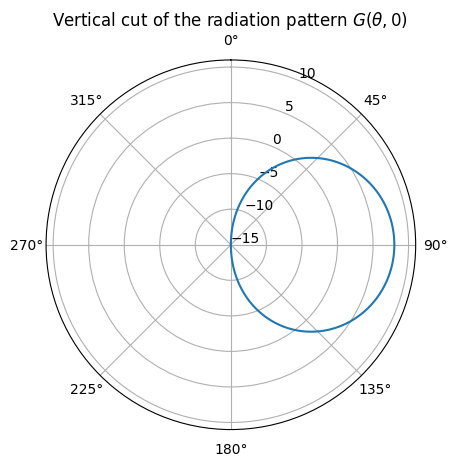

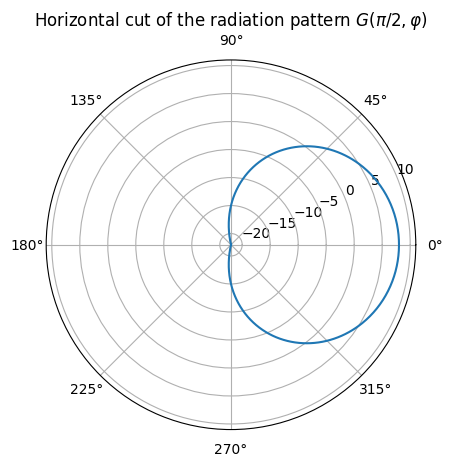

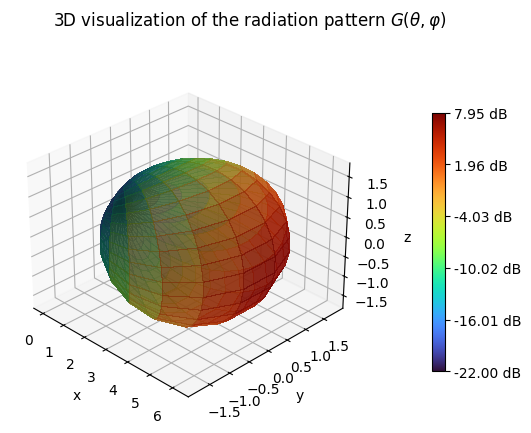

In [208]:
fig_v, fig_h, fig_3d = sionna.rt.antenna.visualize(sionna.rt.antenna.tr38901_pattern)

In [157]:
cm = scene.coverage_map(num_samples=20e6, # Reduce if your GPU does not have enough memory
                        cm_cell_size=cm_cell_size,los=LOS, reflection=REFLECTION,
                        diffraction=DIFFRACTION, scattering=SCATTERING,  # Enables diffraction and scattering in addition to reflection and LoS
                        check_scene=False) # Don't check the scene prior to compute to speed things up)

In [246]:
#cm.show();

#### Define the target area and create coverage objec just for that area (For later use)

In [231]:
set_target_area(selected_rectangle,1.5)

In [232]:
target_cm = scene.coverage_map(cm_center=target_center,
                                   cm_orientation=target_orientation, 
                                   cm_size=target_size,
                                   cm_cell_size=cm_cell_size,
                                   los=True, reflection=False,
                                   diffraction=False, scattering=False,
                                   check_scene=False)

[-120.67125302  -99.32946177] [-547.77277 -546.5071 ]
[213. 223.]


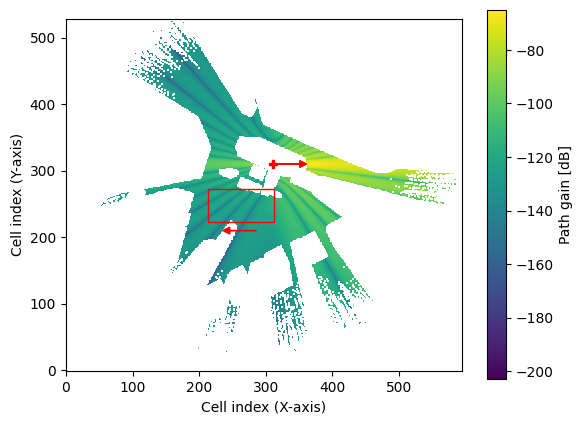

In [233]:
#fig = scene.render(scene_cam,num_samples=1024,fov=42,resolution=(1024,768),paths=None,show_devices=True)
fig = cm.show()
visualize_target_area(fig.axes[0], cm_cell_size, target_center, target_size)
for name, data in transmitter_data.items():
    visualize_Transmitter(fig.axes[0],cm_cell_size, data['position_26915'][0],data['position_26915'][1],
                          data['position_26915'][2],data['initial_orientation'][0])


## Optimization Code

In [215]:
#### Define Objective/loss functions

In [216]:
def compute_loss_max_bit_rate(**orientations): ## This will maximize only bit rate
    #scene.transmitters['tx3'].orientation = [azimuth,0.0,0.0]
    for key, value in orientations.items():
        transmitter_id = key.split('_')[-1]  # This will give 'tx3', 'tx4', etc.
        scene.transmitters[transmitter_id].orientation = [value,0.0,0.0]
        #print("Transmitter ID:", transmitter_id)
        #print("Value:", value)
    """Compute the loss function."""
    target_cm = scene.coverage_map(cm_center=target_center,
                                   cm_orientation=target_orientation, 
                                   cm_size=target_size,
                                   cm_cell_size=cm_cell_size,
                                   los=LOS, reflection=REFLECTION,
                        diffraction=DIFFRACTION, scattering=SCATTERING,
                                   check_scene=False)
    #print(LOS,REFLECTION,DIFFRACTION,SCATTERING)
    target_cm_tensor = tf.maximum(target_cm.as_tensor(), 1e-12)
    scaling = 1e7
    rate = tf.sqrt(tf.reduce_max(tf.math.log(1. + target_cm_tensor * scaling)) / tf.math.log(2.))
    return rate

def compute_loss_max_coverage(**orientations): ## This will maximize total coverage
    #scene.transmitters['tx3'].orientation = [azimuth,0.0,0.0]
    for key, value in orientations.items():
        transmitter_id = key.split('_')[-1]  # This will give 'tx3', 'tx4', etc.
        scene.transmitters[transmitter_id].orientation = [value,0.0,0.0]
        #print("Transmitter ID:", transmitter_id)
        #print("Value:", value)
    """Compute the loss function."""
    target_cm = scene.coverage_map(cm_center=target_center,
                                   cm_orientation=target_orientation, 
                                   cm_size=target_size,
                                   cm_cell_size=cm_cell_size,
                                   los=LOS, reflection=REFLECTION,
                        diffraction=DIFFRACTION, scattering=SCATTERING,
                                   check_scene=False)
    #print(LOS,REFLECTION,DIFFRACTION,SCATTERING)
    target_cm_tensor = tf.maximum(target_cm.as_tensor(), 1e-12)
    max_coverage = tf.reduce_max(target_cm_tensor, axis=0)  # Along the transmitter dimension (assuming axis=0)

    # Calculate the minimum coverage value across all points in the grid
    avg_max_coverage = tf.reduce_sum(max_coverage)
    return 10 * (tf.math.log(1000*avg_max_coverage)/tf.math.log(10.0))

def compute_loss_max_sinr_and_coverage(**orientations): ## This will maximize SINR as well as Coverage
    #scene.transmitters['tx3'].orientation = [azimuth,0.0,0.0]
    for key, value in orientations.items():
        transmitter_id = key.split('_')[-1]  # This will give 'tx3', 'tx4', etc.
        scene.transmitters[transmitter_id].orientation = [value,0.0,0.0]
        #print("Transmitter ID:", transmitter_id)
        #print("Value:", value)
    """Compute the loss function."""
    target_cm = scene.coverage_map(cm_center=target_center,
                                   cm_orientation=target_orientation, 
                                   cm_size=target_size,
                                   cm_cell_size=cm_cell_size,
                                   los=LOS, reflection=REFLECTION,
                        diffraction=DIFFRACTION, scattering=SCATTERING,
                                   check_scene=False)
    #print(LOS,REFLECTION,DIFFRACTION,SCATTERING)
    target_cm_tensor = tf.maximum(target_cm.as_tensor(), 1e-12)
    
    max_signal = tf.reduce_max(target_cm_tensor, axis=0)  # Along the transmitter dimension (assuming axis=0)
    # Calculate interference and noise power (power from other transmitters + noise)
    sinr_watts = tf.divide(max_signal,(tf.reduce_sum(target_cm_tensor,axis=0) - max_signal))
    sinr_watts_avg = tf.reduce_mean(sinr_watts)
    # Calculate the minimum coverage value across all points in the grid
    #min_coverage = tf.reduce_mean(max_coverage)
    return (sinr_watts_avg)

In [234]:
from bayes_opt import BayesianOptimization

In [235]:
# Bounded region of parameter space
#pbounds = {'azimuth': (0, 6.28)}
# Define parameter bounds for each orientation
pbounds = {f'orientation_{i}': (0, 2 * 3.14) for i in transmitter_data}

In [236]:
print(pbounds)

{'orientation_tx3': (0, 6.28), 'orientation_tx4': (0, 6.28)}


In [220]:
optimizer = BayesianOptimization(
    f=compute_loss_max_coverage,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [248]:
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   | orient... | orient... |
-------------------------------------------------
| 25        | -35.51    | 2.492     | 3.384     |
| 26        | -36.83    | 2.633     | 4.303     |
| 27        | -11.63    | 4.632     | 6.28      |
| 28        | -10.25    | 3.973     | 5.471     |
| 29        | -10.19    | 6.28      | 1.881     |
| 30        | -9.935    | 3.423     | 1.962     |
| 31        | -8.414    | 4.445     | 1.63      |
| 32        | -10.58    | 4.083     | 4.3       |
| 33        | -7.16     | 4.666     | 2.435     |
| 34        | -10.98    | 2.821     | 1.386     |
| 35        | -10.68    | 1.005     | 1.62      |
| 36        | -9.83     | 2.009     | 2.032     |


In [249]:
# Access the optimized parameters and maximum value found
best_orientations = [optimizer.max['params'][f'orientation_{i}'] for i in transmitter_data]
best_value = optimizer.max['target']

print("Best Orientations:", best_orientations)
print("Best Objective Value:", best_value)

Best Orientations: [4.035741090650012, 2.4040366756893636]
Best Objective Value: -6.938612937927246


In [250]:
for name, data in transmitter_data.items():
    scene.transmitters[name].orientation = [optimizer.max['params'][f'orientation_{name}'],0.0,0.0]

In [240]:
cm_new = scene.coverage_map(num_samples=40e6, # Reduce if your GPU does not have enough memory
                            cm_cell_size=[2,2],
                            los=True, reflection=False,
                                   diffraction=False, scattering=False, # Enable diffraction and scattering in addition to reflection and LoS
                            check_scene=False) # Don't check the scene prior to compute to speed things up

[-120.67125302  -99.32946177] [-547.77277 -546.5071 ]
[213. 223.]
[-120.67125302  -99.32946177] [-547.77277 -546.5071 ]
[213. 223.]


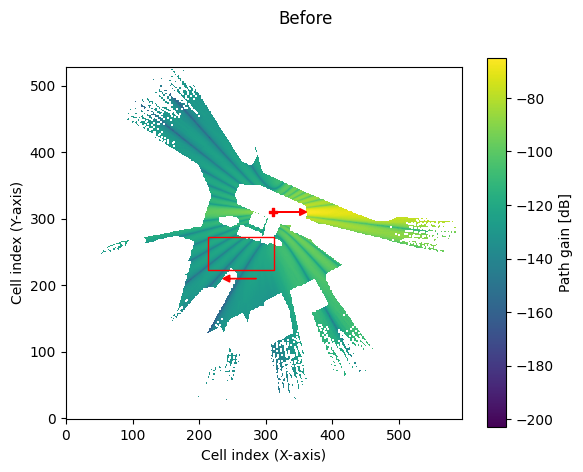

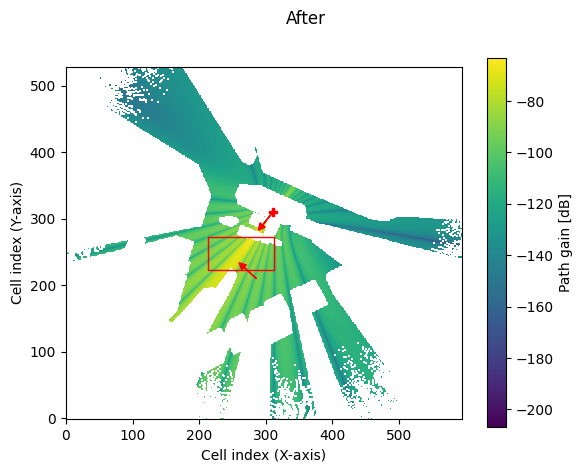

In [251]:
# Display the initial coverage map
fig = cm.show()
fig.suptitle("Before")
# Highlight the target area
visualize_target_area(fig.axes[0], cm_cell_size, target_center, target_size,)
for name, data in transmitter_data.items():
    visualize_Transmitter(fig.axes[0],cm_cell_size, data['position_26915'][0],data['position_26915'][1],
                          data['position_26915'][2],data['initial_orientation'][0])

# Display the optimized coverage map
fig = cm_new.show()
fig.suptitle("After")
# Highlight the target area
visualize_target_area(fig.axes[0], cm_cell_size, target_center, target_size)
for transm in scene.transmitters:
    visualize_Transmitter(fig.axes[0],cm_cell_size, scene.get(transm).position[0].numpy(),scene.get(transm).position[1].numpy(),25.0,scene.get(transm).orientation[0].numpy())


In [242]:
target_cm_new = scene.coverage_map(cm_center=target_center,
                                   cm_orientation=target_orientation, 
                                   cm_size=target_size,
                                   cm_cell_size=cm_cell_size,
                                   los=True, reflection=False,
                                   diffraction=False, scattering=False,
                                   check_scene=False)

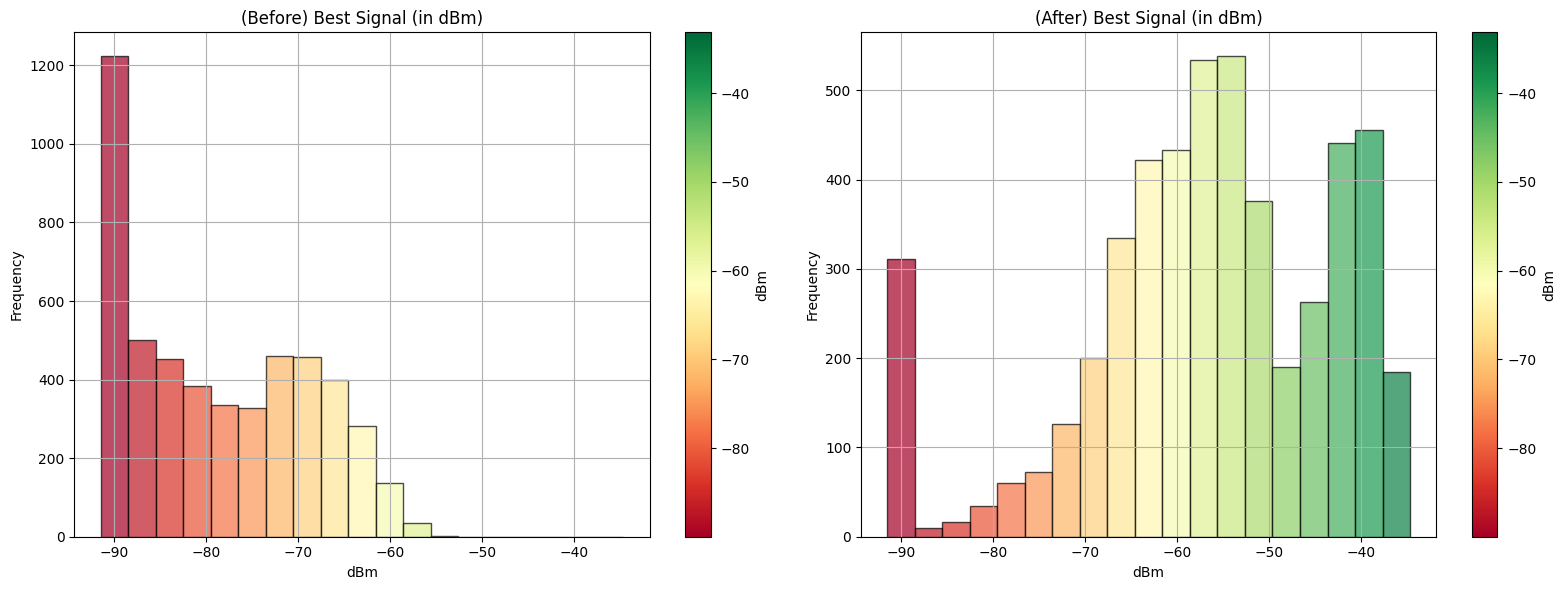

In [252]:
target_cm_tensor = tf.maximum(target_cm.as_tensor(), 1e-12)
target_cm_dbm_tensor = 10 * (tf.math.log(1000*tf.reduce_max(target_cm_tensor,axis=0))/tf.math.log(10.0))
target_cm_dbm_array_before = target_cm_dbm_tensor.numpy().flatten()

target_cm_tensor = tf.maximum(target_cm_new.as_tensor(), 1e-12)
target_cm_dbm_tensor = 10 * (tf.math.log(1000*tf.reduce_max(target_cm_tensor,axis=0))/tf.math.log(10.0))
target_cm_dbm_array_after = target_cm_dbm_tensor.numpy().flatten()

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Define colormap that transitions from red to green based on dBm values
cmap = plt.cm.RdYlGn

# Set min and max dBm values for color mapping (adjust based on your data)
min_dbm = min(np.min(target_cm_dbm_array_before), np.min(target_cm_dbm_array_after))
max_dbm = max(np.max(target_cm_dbm_array_before), np.max(target_cm_dbm_array_after))

# Define bins for histograms
bins = np.linspace(min_dbm, max_dbm, 20)

# Plot histogram with specified bins and colors based on dBm values (Before)
counts_before, _ = np.histogram(target_cm_dbm_array_before, bins=bins)
colors_before = [cmap((dbm - min_dbm) / (max_dbm - min_dbm)) for dbm in bins[:-1]]
axes[0].bar(bins[:-1], counts_before, width=np.diff(bins), color=colors_before, edgecolor='black', alpha=0.7)

# Plot histogram with specified bins and colors based on dBm values (After)
counts_after, _ = np.histogram(target_cm_dbm_array_after, bins=bins)
colors_after = [cmap((dbm - min_dbm) / (max_dbm - min_dbm)) for dbm in bins[:-1]]
axes[1].bar(bins[:-1], counts_after, width=np.diff(bins), color=colors_after, edgecolor='black', alpha=0.7)

# Add colorbars for reference
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min_dbm, max_dbm))
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=axes[0])
cbar1.set_label('dBm')

sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min_dbm, max_dbm))
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=axes[1])
cbar2.set_label('dBm')

# Set titles, labels, and grid for the first subplot
axes[0].set_title('(Before) Best Signal (in dBm)')
axes[0].set_xlabel('dBm')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Set titles, labels, and grid for the second subplot
axes[1].set_title('(After) Best Signal (in dBm)')
axes[1].set_xlabel('dBm')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

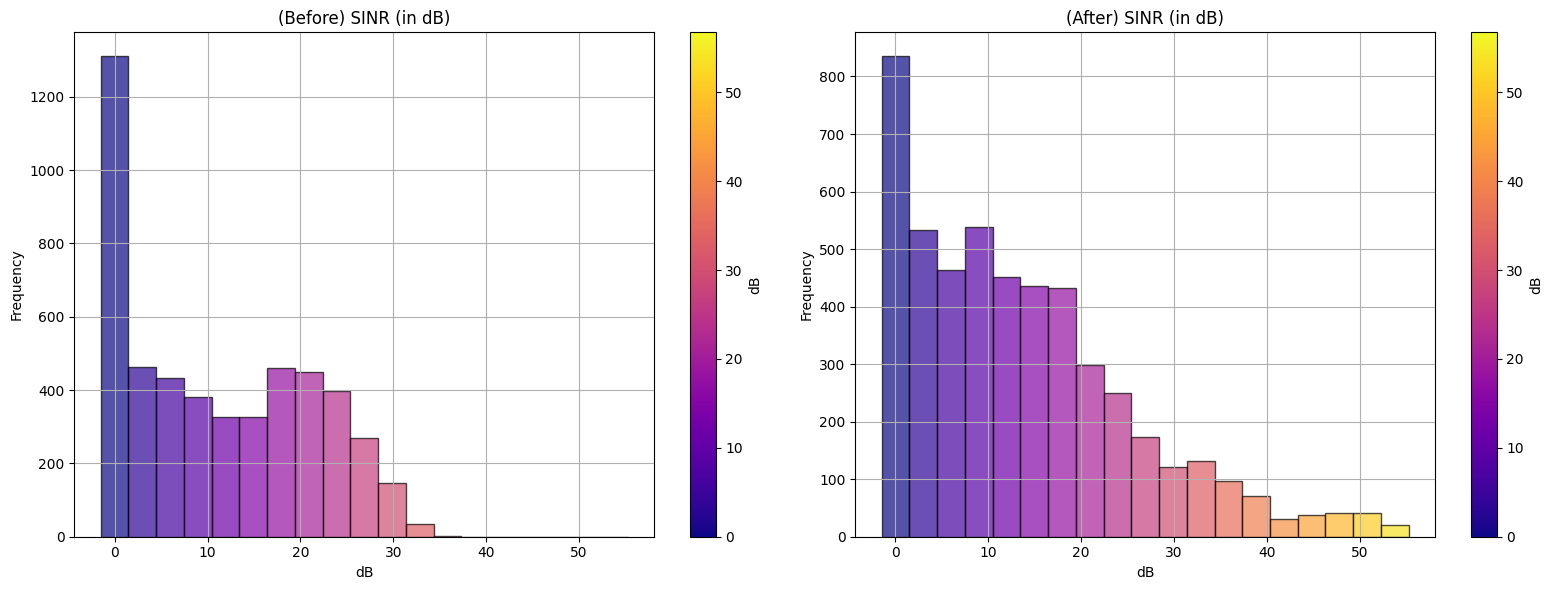

In [253]:
target_cm_tensor = tf.maximum(target_cm.as_tensor(), 1e-12)
best_signal_tensor = tf.reduce_max(target_cm_tensor,axis=0)
Interference_tensor = tf.reduce_sum(target_cm_tensor,axis=0) - tf.reduce_max(target_cm_tensor,axis=0)
sinr_tensor = tf.divide(best_signal_tensor,Interference_tensor)
target_cm_dbm_tensor = 10 * (tf.math.log(sinr_tensor)/tf.math.log(10.0))
target_cm_dbm_array_before = target_cm_dbm_tensor.numpy().flatten()

target_cm_tensor = tf.maximum(target_cm_new.as_tensor(), 1e-12)
best_signal_tensor = tf.reduce_max(target_cm_tensor,axis=0)
Interference_tensor = tf.reduce_sum(target_cm_tensor,axis=0) - tf.reduce_max(target_cm_tensor,axis=0)
sinr_tensor = tf.divide(best_signal_tensor,Interference_tensor)
target_cm_dbm_tensor = 10 * (tf.math.log(sinr_tensor)/tf.math.log(10.0))
target_cm_dbm_array_after = target_cm_dbm_tensor.numpy().flatten()

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Define colormap that transitions from red to green based on dBm values
cmap = plt.cm.plasma

# Set min and max dBm values for color mapping (adjust based on your data)
min_dbm = min(np.min(target_cm_dbm_array_before), np.min(target_cm_dbm_array_after))
max_dbm = max(np.max(target_cm_dbm_array_before), np.max(target_cm_dbm_array_after))

# Define bins for histograms
bins = np.linspace(min_dbm, max_dbm, 20)

# Plot histogram with specified bins and colors based on dBm values (Before)
counts_before, _ = np.histogram(target_cm_dbm_array_before, bins=bins)
colors_before = [cmap((dbm - min_dbm) / (max_dbm - min_dbm)) for dbm in bins[:-1]]
axes[0].bar(bins[:-1], counts_before, width=np.diff(bins), color=colors_before, edgecolor='black', alpha=0.7)

# Plot histogram with specified bins and colors based on dBm values (After)
counts_after, _ = np.histogram(target_cm_dbm_array_after, bins=bins)
colors_after = [cmap((dbm - min_dbm) / (max_dbm - min_dbm)) for dbm in bins[:-1]]
axes[1].bar(bins[:-1], counts_after, width=np.diff(bins), color=colors_after, edgecolor='black', alpha=0.7)

# Add colorbars for reference
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min_dbm, max_dbm))
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=axes[0])
cbar1.set_label('dB')

sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(min_dbm, max_dbm))
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=axes[1])
cbar2.set_label('dB')

# Set titles, labels, and grid for the first subplot
axes[0].set_title('(Before) SINR (in dB)')
axes[0].set_xlabel('dB')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Set titles, labels, and grid for the second subplot
axes[1].set_title('(After) SINR (in dB)')
axes[1].set_xlabel('dB')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

In [ ]:
scene.preview(coverage_map=cm_new)